In this notebook we set out to address 4 questions:

1) whether students of one foreign language perform better than students of another 

2) whether the room a course is taught in affects grades 

3) whether students in classes that start at 1 PM perform better than students in classes that 8 AM 

4) whether there are more classes at 1 PM than 8 AM
 

We begin by importing Python libraries necessary to retrieve, store, and statistically analyze the data.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
import seaborn
conn = sqlite3.connect('database.sqlite3')
c = conn.cursor()

Below utility functions that transfer data into a pandas DataFrame and normalize grade counts are defined.

In [238]:
def make_df(curs):
    """Fetches data from a sqlite cursor, enters data into a pandas DataFrame, and returns the DataFrame"""
    names = [d[0] for d in curs.description]
    df = pd.DataFrame(curs.fetchall(), columns = names)
    return df

def normalize_grades(col_name, df):
    """Divides grade count by total number of letter grades awarded to a class and creates a new column
    in DataFrame to store the quotient"""
    
    n = col_name + '_normalized'
    df[n] = df[col_name]/df['total_grades']
    return df

We will first address the question of whether students of one foreign language perform better than students of other foreign languages.  We will address this question with two statistical tests: an ANOVA comparing the proportion of students that pass classes in each foreign language and an ANOVA comparing the proportion of students who make a B or better in each foreign language.

In order to address this question, we must query the database for all letter grades, pass/fail grades (coded as satisfactory/unsatisfactory by UW-Madison), credit received, and no report, as well as course name and subject each course belongs to.

In [239]:
c.execute('''SELECT a_count, ab_count, b_count, bc_count, c_count, d_count, f_count, s_count, u_count, cr_count, n_count,nr_count, courses.name as course_name, subjects.name as subject_name, subjects.abbreviation FROM grade_distributions JOIN course_offerings ON grade_distributions.course_offering_uuid = course_offerings.uuid JOIN courses ON course_offerings.course_uuid = courses.uuid JOIN subject_memberships USING (course_offering_uuid) JOIN subjects ON subject_memberships.subject_code = subjects.code''')

We transfer the data from the cursor to a pandas DataFrame.

In [240]:
fl_precursor = make_df(c)

In order to address whether students perform better in one foreign language than others, we subsample the dataframe to obtain a dataframe that contains only data from foreign language classes.

In [241]:
fl = fl_precursor[fl_precursor['subject_name'].isin(['Portuguese (Spanish and Portuguese)','French (French and Italian)', 'German', 'Slavic (Slavic Languages)', 'Italian (French and Italian)','Spanish (Spanish and Portuguese)','African Languages and Literature','Hebrew-Modern','Hebrew-Biblical','Languages and Cultures of Asia - Languages','East Asian Languages and Literature'])]

In [48]:
fl.columns

Index(['a_count', 'ab_count', 'b_count', 'bc_count', 'c_count', 'd_count',
       'f_count', 's_count', 'u_count', 'cr_count', 'n_count', 'nr_count',
       'course_name', 'subject_name', 'abbreviation', 'total_grades',
       'avg_grade'],
      dtype='object')

We can see that there are two groups of Asian language classes: "Languages and Cultures of Asia - Languages" and "East Asian Languages and Literature". Let's rename these groups so that they are consolidated into one group of Asian languages.

In [242]:
fl['subject_name'] = fl['subject_name'].str.replace('East Asian Languages and Literature','Asian Languages')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [243]:
fl['subject_name'] = fl['subject_name'].str.replace('Languages and Cultures of Asia - Languages','Asian Languages')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Grade counts are currently stored as strings.  We must convert them to type int.

In [250]:
to_convert = ['a_count',
             'ab_count',
              'b_count',
             'bc_count',
             'c_count',
             'd_count',
             'f_count',
             's_count']
for col in to_convert:
    fl[col] = fl[col].astype(int)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


The column 'total_grades' contains a count of how many letter grades were awarded to each class.

In [245]:
fl['total_grades'] = fl['a_count'] +fl['ab_count']+fl['b_count']+fl['bc_count']+fl['c_count']+fl['d_count']+fl['f_count']

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [225]:
fl.tail()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,u_count,cr_count,n_count,nr_count,course_name,subject_name,abbreviation,total_grades,avg_grade
211643,5,1,8,4,3,0,0,0,0,0,0,0,Hispanic Screen Studies,Spanish (Spanish and Portuguese),SPANISH,21,3.023810
211671,0,0,0,0,0,0,0,0,0,0,0,0,German Literary Movements Since 1750,German,GERMAN,0,NaN
211696,0,0,0,0,0,0,0,0,0,0,0,0,Advanced Near Eastern Languages,Hebrew-Biblical,HEBR-BIB,0,NaN
211709,0,0,0,0,0,0,0,0,0,0,0,0,Pentateuchal Narratives,Hebrew-Biblical,HEBR-BIB,0,NaN
211756,4,3,2,0,0,0,0,0,0,0,0,0,Seminar in African Cultural Studies: Topics,African Languages and Literature,AFRICAN,9,3.611111


In [195]:
no_letter_grades = fl[fl['total_grades'] == 0]
no_letter_grades.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,s_count,u_count,cr_count,n_count,nr_count,course_name,subject_name,abbreviation,total_grades,avg_grade
3527,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0,NaN
3530,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0,NaN
3539,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0,NaN
3545,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0,NaN
3548,0,0,0,0,0,0,0,0,0,0,0,0,First Semester Portuguese,Portuguese (Spanish and Portuguese),PORTUG,0,NaN


Looking at the DataFrame, we can see that there are a few classes in which no letter grades were awarded.  These classes were not taken exclusively pass/fail (or satisfactory/unsatisfactory in the terminology used by UW-Madison), nor is there a record that the professor submitted 'no report' for these classes.  Since it is not clear how students performed in these classes, classes for which no letter grades were awarded will be dropped from the DataFrame.

In [255]:
df = fl.drop(fl[fl['total_grades']==0].index)

In [256]:
for col in to_convert:
    df = normalize_grades(col,df)

In [257]:
df['prop_pass'] = (df['a_count'] +df['ab_count']+df['b_count']+df['bc_count']+df['c_count']+df['s_count'])/(df['total_grades']+df['s_count'])

In [258]:
df['prop_high'] = (df['a_count'] +df['ab_count'] +df['b_count'])/df['total_grades']

Before we conduct statistical tests, let's examine a plot of the proportions of letter grades awarded to classes in each foreign language.

In [259]:
means = df.groupby('subject_name').agg('mean')

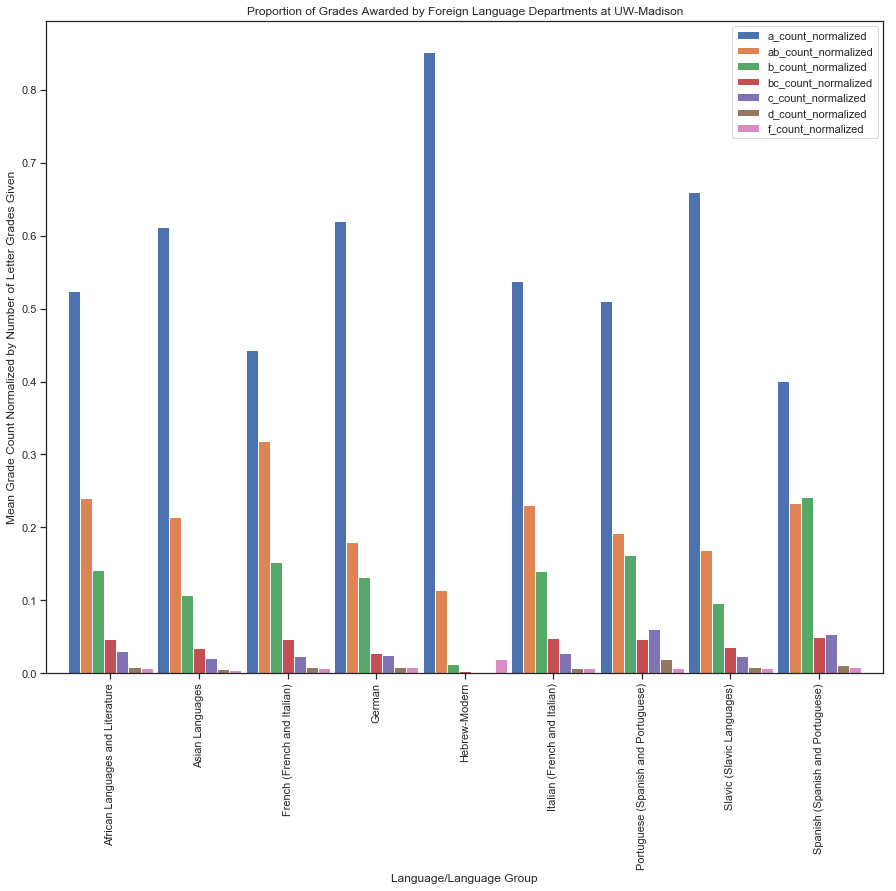

In [262]:
ax = means.drop(columns = ['a_count','ab_count','bc_count','b_count','c_count','d_count','f_count','total_grades','s_count','prop_pass','prop_high','s_count_normalized','avg_grade']).plot.bar(width = 0.95, figsize = (15,12))
ax.set_ylabel('Mean Grade Count Normalized by Number of Letter Grades Given')
ax.set_title('Proportion of Grades Awarded by Foreign Language Departments at UW-Madison')
ax.set_xlabel('Language/Language Group')
plt.show()

Looking at a bar graph of normalized grade count, it appears that more A's are awarded in Hebrew classes than to classes in any other language.  We will look at average class size as well as total number of classes in each foreign langauge to determine whether either of these factors could be influencing the large proportion of A's awarded to Hebrew students.

In [218]:
avg_class_size = df.groupby('subject_name')['total_grades'].mean()

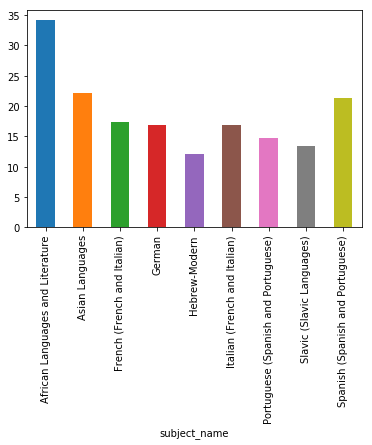

In [219]:
avg_class_size.plot.bar()

Hebrew classes do appear to be smaller than classes in other langauges, but classes in Slavic languages and Portuguese are not much larger on average by comparison.  

In [221]:
num_classes = df.groupby('subject_name').count()

In [263]:
num_classes['total_grades']

subject_name
African Languages and Literature        498
Asian Languages                        1250
French (French and Italian)            1374
German                                  976
Hebrew-Modern                            14
Italian (French and Italian)            698
Portuguese (Spanish and Portuguese)     277
Slavic (Slavic Languages)               441
Spanish (Spanish and Portuguese)       3171
Name: total_grades, dtype: int64

There are only 14 Hebrew classes total.  This sample size is too dissimilar from that of the other languages to obtain reliable results from an ANOVA.  We will exclude Hebrew classes from our analysis.

In [264]:
df_minus_Hebrew= df[df['subject_name'] !='Hebrew-Modern']

In [290]:
df_minus_Hebrew['boxcox_prop_high']=scipy.stats.boxcox(df_minus_Hebrew['prop_high'],lmbda = -3)[0]

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [292]:
df_minus_Hebrew['log_prop_high']=np.log(df_minus_Hebrew['prop_high'])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [312]:
from sklearn.preprocessing import quantile_transform
trans = quantile_transform(df_minus_Hebrew['prop_high'].as_matrix().reshape(-1,1))
x = trans.flatten()
df_minus_Hebrew['trans_prop_high'] = x

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


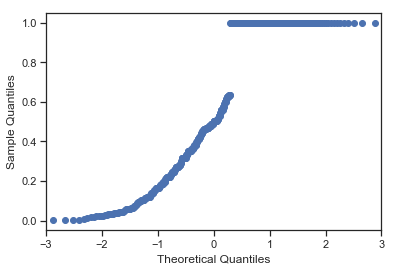

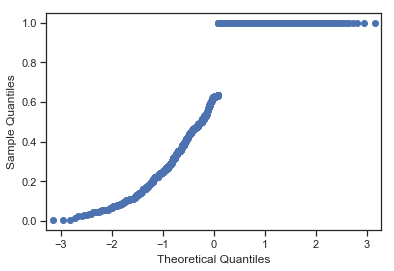

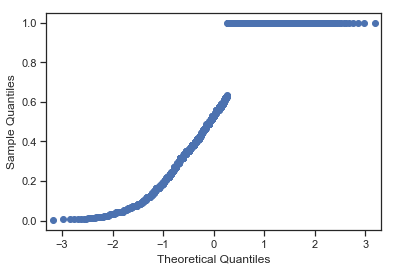

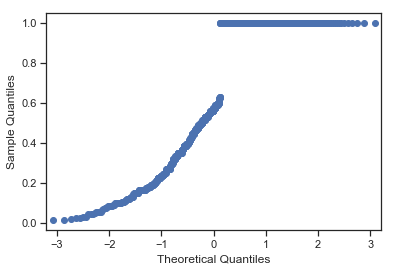

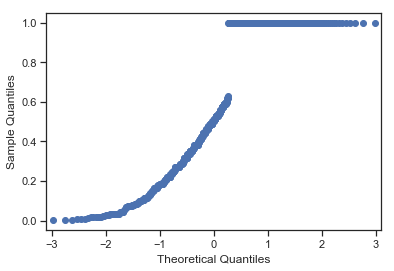

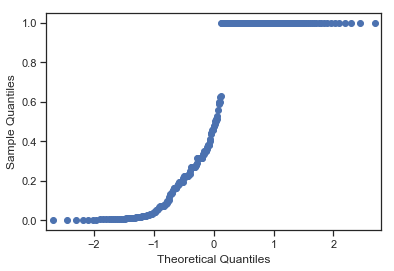

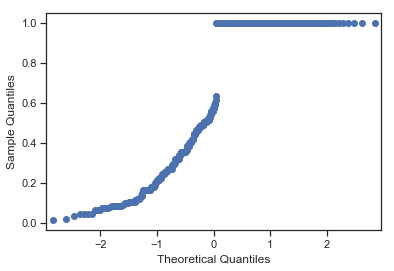

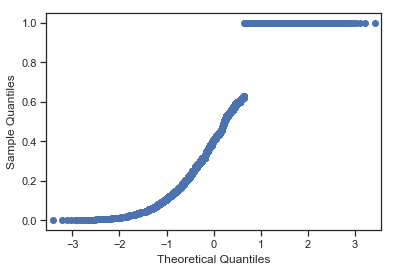

In [313]:
from statsmodels.graphics.gofplots import qqplot
for group in subj.groups:
    qqplot(df_minus_Hebrew[df_minus_Hebrew['subject_name']== group]['trans_prop_high'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3aca8048>,
      dtype=object)

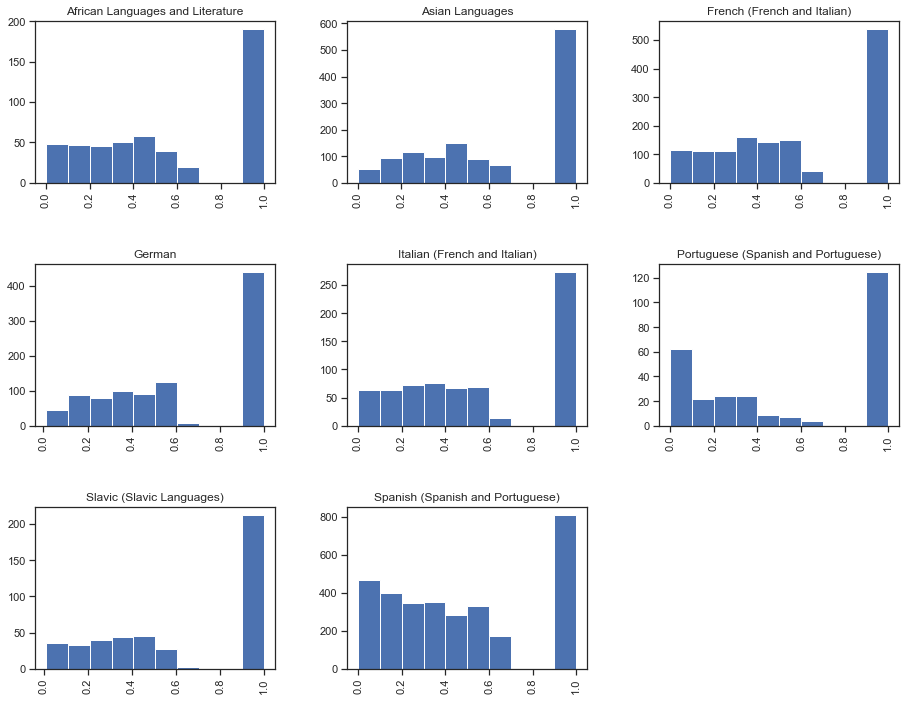

In [314]:
df_minus_Hebrew['trans_prop_high'].hist(by = df_minus_Hebrew['subject_name'], figsize = (15,12))

ANOVA test requires: 

1) that each sample be drawn from a normally distributed population

2) independent samples

3) equal variances between samples

In order to verify these assumptions, we examine histograms of the proportion of students who passed for each foreign language as well as the proportion of students who made higher than a B in each foreign language.

In [316]:
from scipy import stats
stats.pareto.fit(df_minus_Hebrew['prop_high'])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Estimated location parameter for the data.


(87713.98434686995, -49739.01461616624, 49739.01461622803)

In [319]:
df_minus_Hebrew['pareto_high'] = df['prop_high']**stats.pareto.fit(df_minus_Hebrew['prop_high'])[2]

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Estimated location parameter for the data.
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3aca8d68>,
      dtype=object)

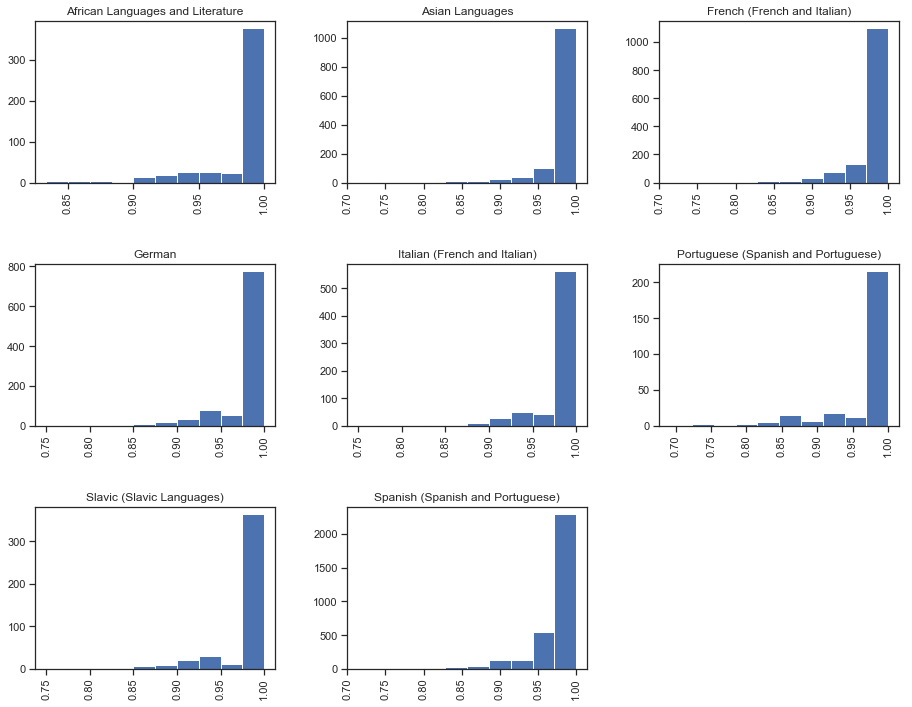

In [265]:
df_minus_Hebrew['prop_pass'].hist(by = df_minus_Hebrew['subject_name'], figsize = (15,12))

A quick look at the histograms of proportion of students who passed makes it clear that these distributions are not normal.  In this case, it would not be appropriate to perform an ANOVA. Instead, we should perform a Kruskal-Wallis test.

In [321]:
df_minus_Hebrew['pareto_pass'] = df['prop_pass']**stats.pareto.fit(df_minus_Hebrew['prop_high'])[0]

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Estimated location parameter for the data.
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a375eb5f8>,
      dtype=object)

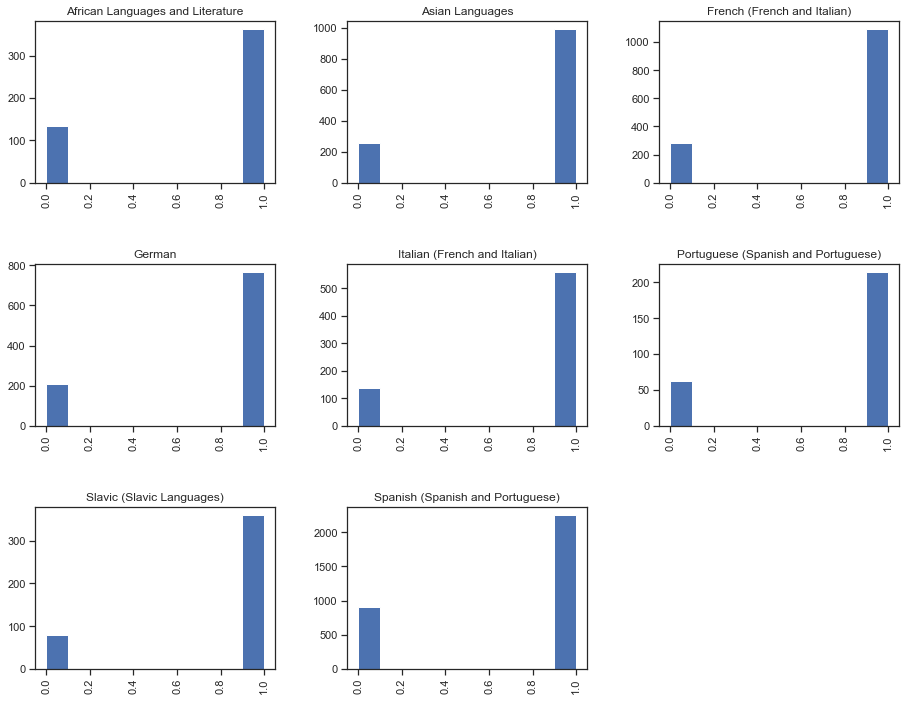

In [322]:
df_minus_Hebrew['pareto_pass'].hist(by = df_minus_Hebrew['subject_name'], figsize = (15,12))

In [124]:
subj = df_minus_Hebrew.groupby('subject_name')

In [266]:
scipy.stats.kruskal(*[list(df_minus_Hebrew[df_minus_Hebrew['subject_name']== group]['prop_pass']) for group in subj.groups])

KruskalResult(statistic=69.81605908288448, pvalue=1.6094406697192378e-12)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a367e40b8>,
      dtype=object)

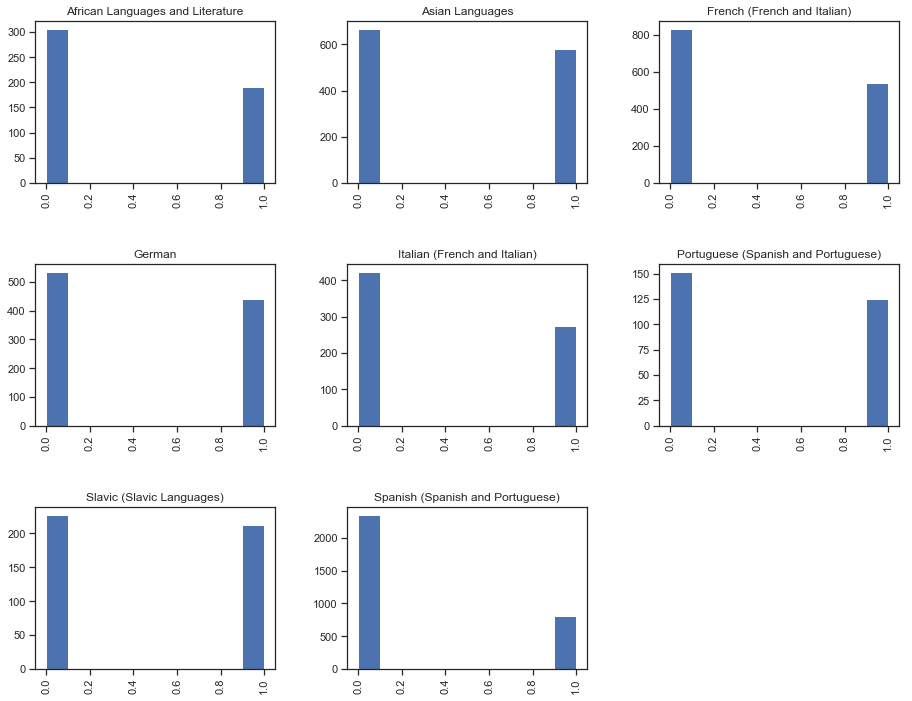

In [320]:
df_minus_Hebrew['pareto_high'].hist(by = df_minus_Hebrew['subject_name'], figsize = (15,12))

In [236]:
from pingouin import pairwise_gameshowell
pairwise_gameshowell(dv='avg_grade', between='subject_name', data=df_minus_Hebrew)

,A,B,mean(A),mean(B),diff,SE,tail,T,df,pval,efsize,eftype
0,African Languages and Literature,Asian Languages,3.551,3.654,-0.102,0.010,two-sided,-7.145,840.006,0.001000,-0.378,hedges
1,African Languages and Literature,French (French and Italian),3.551,3.519,0.033,0.010,two-sided,2.253,883.772,0.555649,0.118,hedges
2,African Languages and Literature,German,3.551,3.631,-0.080,0.011,two-sided,-5.342,948.117,0.001000,-0.294,hedges
3,African Languages and Literature,Italian (French and Italian),3.551,3.565,-0.013,0.012,two-sided,-0.796,1089.084,0.900000,-0.047,hedges
4,African Languages and Literature,Portuguese (Spanish and Portuguese),3.551,3.464,0.087,0.018,two-sided,3.377,444.383,0.017238,0.253,hedges
5,African Languages and Literature,Slavic (Slavic Languages),3.551,3.666,-0.114,0.013,two-sided,-6.452,931.032,0.001000,-0.422,hedges
6,African Languages and Literature,Spanish (Spanish and Portuguese),3.551,3.393,0.158,0.010,two-sided,11.624,718.423,0.001000,0.560,hedges
7,Asian Languages,French (French and Italian),3.654,3.519,0.135,0.007,two-sided,13.053,2621.860,0.001000,0.510,hedges
8,Asian Languages,German,3.654,3.631,0.022,0.008,two-sided,2.038,2057.987,0.458502,0.087,hedges
9,Asian Languages,Italian (French and Italian),3.654,3.565,0.089,0.009,two-sided,6.894,1295.478,0.001000,0.326,hedges


In [119]:
avg_gpa = df_minus_Hebrew.groupby('subject_name')['avg_grade'].agg('mean')

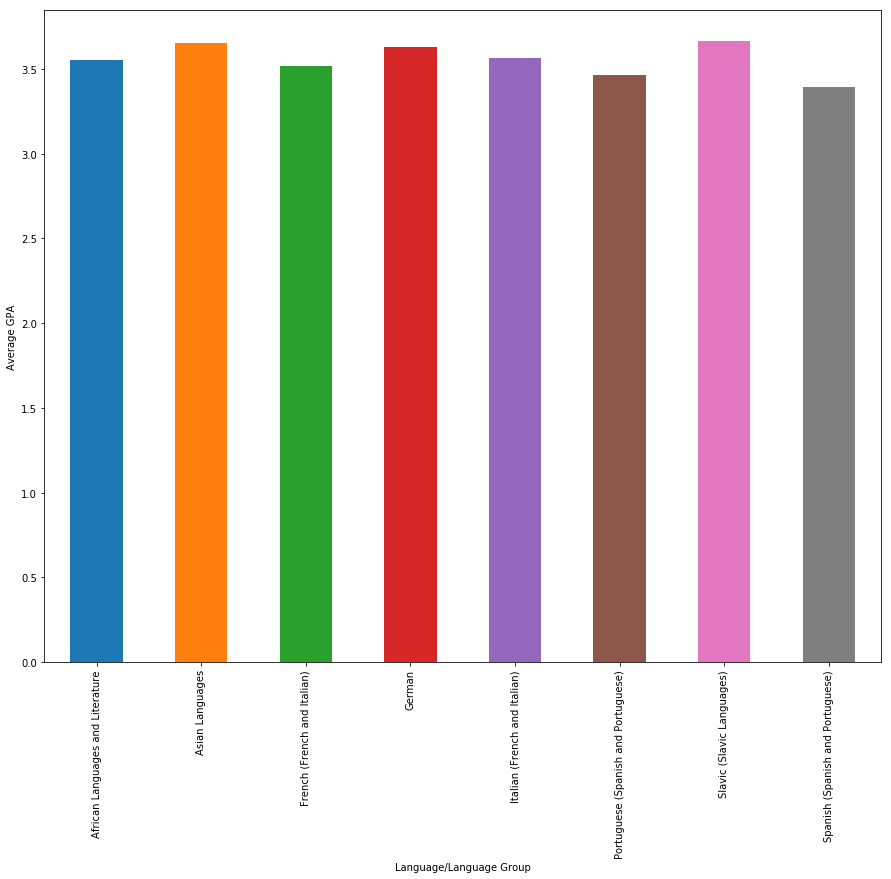

In [177]:
gpa = avg_gpa.plot.bar(figsize = (15,12))
gpa.set_xlabel('Language/Language Group')
gpa.set_ylabel('Average GPA')
plt.show()
# plt.ylim((2.5,4.0))

In [89]:
num_students = df.groupby('subject_name')['total_grades'].agg('sum')

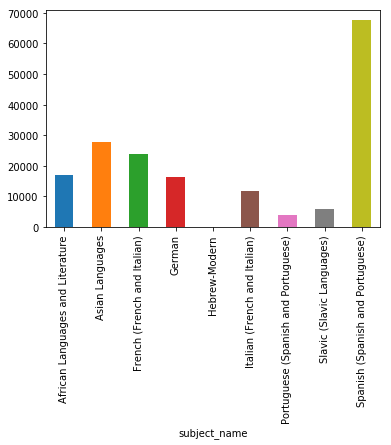

In [91]:
num_students.plot.bar()

In [126]:
means = df_minus_Hebrew.groupby('subject_name').agg('mean')

In [127]:
means.rename({'French (French and Italian)': 'French', 'Italian (French and Italian)': 'Italian', 'Portuguese (Spanish and Portuguese)': 'Portuguese','Slavic (Slavic Languages)':'Slavic Languages', 'Spanish (Spanish and Portuguese)': 'Spanish'},inplace = True)

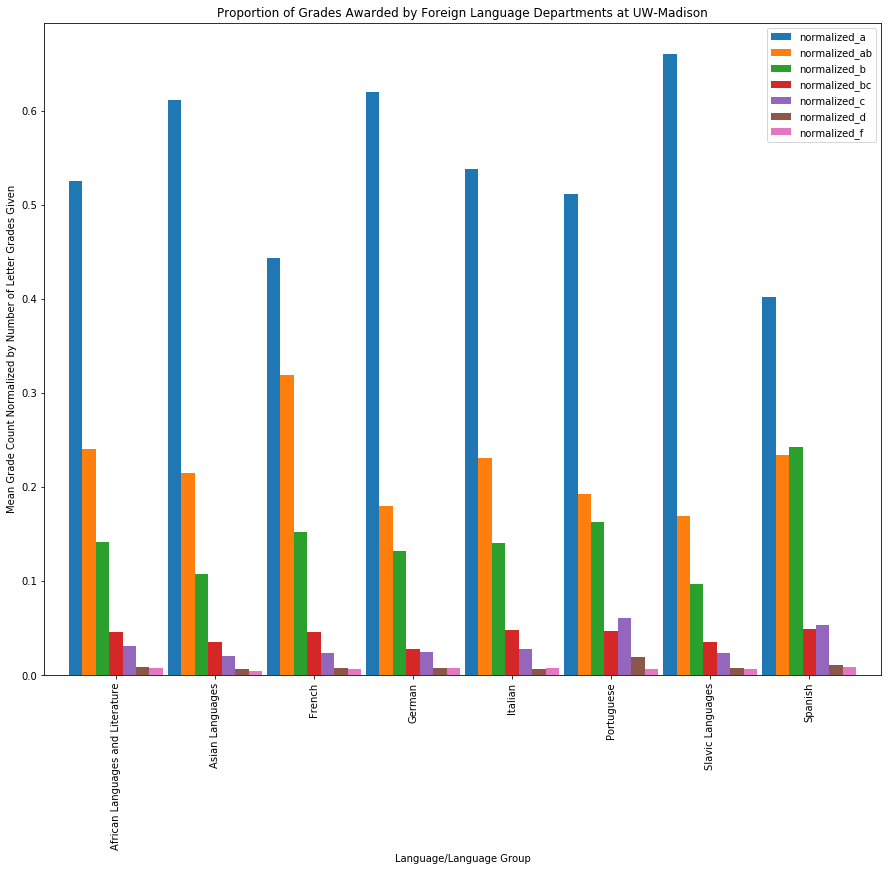

In [176]:
ax = means.drop(columns = ['a_count','ab_count','bc_count','b_count','c_count','d_count','f_count','avg_grade','total_grades']).plot.bar(width = 0.95, figsize = (15,12))
ax.set_ylabel('Mean Grade Count Normalized by Number of Letter Grades Given')
ax.set_title('Proportion of Grades Awarded by Foreign Language Departments at UW-Madison')
ax.set_xlabel('Language/Language Group')
plt.savefig('bar_graph_minus_Hebrew')
plt.show()